# GLMS -- SingleRFs 

In [1]:
import sys
import os
import h5py 

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

if myhost=='mt': # this is sigur
    print("Sure about this?")
#    sys.path.insert(0, '/home/jake/Repos/')
#    dirname = os.path.join('.', 'checkpoints')
#    datadir = '/home/dbutts/V1/Conway/'
else:
    sys.path.insert(0, '/home/felixbartsch/Code/') 
    datadir = '/Data/FelixData/Conway/'  
    dirname = '/home/felixbartsch/Data/Colorworkspace/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
import dill
import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.RFutils as RU
from ColorDataUtils.multidata_utils import MultiExperiment

from NTdatasets.generic import GenericDataset
import NTdatasets.conway.cloud_datasets as datasets
import NTdatasets.conway.bar1d_datasets as bardatasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

%load_ext autoreload
%autoreload 2

Running on Computer: [m1]
Invoking __init__.py for NDNT.utils
Setting light mode
Save_dir = /home/felixbartsch/Data/Colorworkspace/


/home/felixbartsch/anaconda3/envs/torch38/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#data directory structs
fndate = '0715'
#dirname2 = dirname+fndate+'/'
#dirname_mod = dirname+fndate+'/models/'

#data directory structs
PROOT = 'J22'+fndate
fn = PROOT+'_CC_CC'
fn0 = fn+'_v08'

datadir2 = datadir+'proc/'+PROOT+'/'
analdir = datadir2+'analysis/'
moddir = datadir2+'models/'

In [3]:
useConeInc = True

num_lags = 10
UNX = 52

inclMUs = True
t0 = time()
data = datasets.ColorClouds(
    filenames=[fn0], eye_config=3, drift_interval=16,
    datadir=datadir2, folded_lags=False, luminance_only=False,
    trial_sample=True, num_lags=num_lags, 
    include_MUs=inclMUs)
t1 = time()
print(t1-t0, 'sec elapsed')

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map > 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]
NFunits = np.where((data.channel_map > 32) & (data.channel_map < (32+128)))[0]
print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Pull correct saccades
matdat = sio.loadmat( datadir2+fn+'_ETupdate.mat')
data.process_fixations(matdat['sac_binsB'][0, :])

#sac_ts_all = matdat['ALLsac_bins'][0, :]
#data.process_fixations( sac_ts_all )

#    'tsacs_msB': Bsac_ts,  ## microsaccade times in seconds (4 sec trials)
#    'sac_bins_allB': Bsacbins_all, # bin numbers of sac sampled at 60 Hz
#    'sac_amps_allB': CampsB, ## squared magnitude
#    'sac_ampsB': Bsac_amps, # reduced sac times & amplitude given threshold
#    'sac_binsB': Bsac_bins,
#    'sac_tsB': Bsac_ts,
#    'et60HzB': ETprocB, # downsampled processed eye trace
#    'et1kHzB': et1khzB,

NT = len(data.fix_n)
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))

# # Replace DFs
matdat = sio.loadmat(datadir2+fn+'_DFupdate.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )
data.dfs.shape

#shift robs to test weird NLRF alignment
#data.robs=torch.from_numpy(np.roll(data.robs,shift=8,axis=0))

Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
175.7926642894745 sec elapsed
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 3128 saccades
167520 (167520 valid) time points


torch.Size([167520, 239])

In [4]:
SHfile = sio.loadmat(datadir2 +fn+'_shifts_best.mat')
#SHfile = sio.loadmat(dirname2 + 'BDshifts0628i3.mat')
fix_n  = SHfile['fix_n']
fixshifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts  = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']


In [5]:
## only use most confident fixations
goodfix = np.where(ETmetrics[:,1] < 0.9)
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
data.dfs=np.multiply(data.dfs,valfix)

In [6]:
# Segregate 'valid' Utah units
Reff = torch.mul(data.robs[:, UTunits], data.dfs[:, UTunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valUT = UTunits[a]
NCUT = len(valUT)

Reff = torch.mul(data.robs[:, NFunits], data.dfs[:, NFunits]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valNF = NFunits[a]
NCNF = len(valNF)

Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
valLP = lam_units[a]
NCL = len(valLP)
NCv = len(valLP)

print( "%d out of %d Laminar units kept"%(NCL, len(lam_units)) )
print( "%d out of %d NF units kept"%(NCNF, len(NFunits)) )
print( "%d out of %d Utah units kept"%(NCUT, len(UTunits)) )

21 out of 29 Laminar units kept
15 out of 15 NF units kept
174 out of 195 Utah units kept


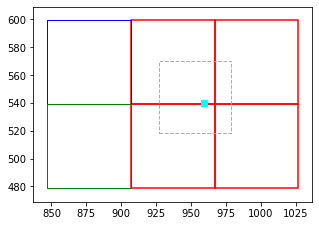

In [7]:
top_corner = np.array([927, 518], dtype=np.int64)
NCv=NCUT

data.draw_stim_locations(top_corner = top_corner, L=UNX)

In [8]:
DKL2CIS = np.array([[0.0401,.522,0],[.0351,-.4635,0],[0.0145,0,.985]])
DKL2ConeInc = np.array([[0.7586, 0.6515, 0], [0.5536, -0.8328, 0], [0.5000, 0, 0.8660]])
#DKL2CIS = np.array([[0,1,0],[0,1,1],[0,0,1]])
if useConeInc:
    DKLconv = deepcopy(DKL2ConeInc)
    ConvID = 'ConeInc'
else:
    DKLconv = deepcopy(DKL2CIS)
    ConvID = 'CIS'
    
ConvID

'ConeInc'

In [9]:
data.assemble_stimulus(top_corner=top_corner, fixdot=0, L=UNX, shifts=-fixshifts)

  Stim expansion for shift: [907, 498, 999, 590]
  Writing lam stim 0: overlap 60, 41
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 41
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 52 x 52
  Done


In [10]:
data.stim = data.stim.cpu().numpy()
data.stim = np.transpose(data.stim.reshape(NT,3,UNX,UNX), (1, 0, 2, 3))
data.stim = np.matmul(DKLconv,data.stim.reshape([3,-1]))
data.stim = np.transpose(data.stim.reshape([3,NT,UNX,UNX]), (1, 0, 2, 3))
data.stim = np.reshape(data.stim, (NT,3*UNX*UNX))
data.stim = torch.tensor(data.stim, dtype=torch.float32)

In [10]:
# LP STAs
Reff = torch.mul(data.robs[:, valUT], data.dfs[:, valUT])
nspks = torch.sum(Reff, axis=0)

lag = 3
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([3,UNX,UNX,-1]).numpy()

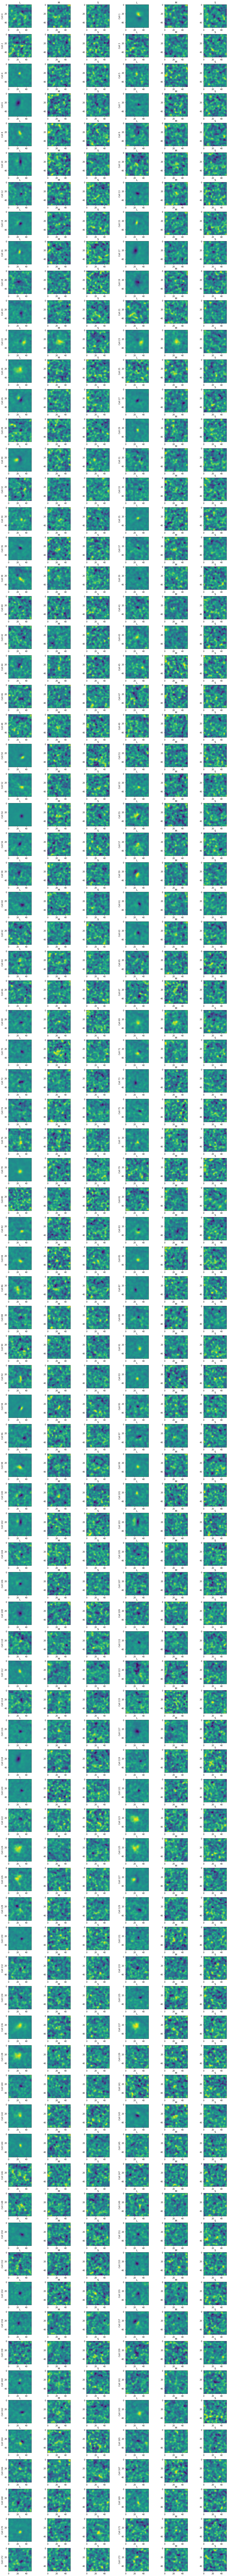

In [11]:
ctext = ['L', 'M', 'S']
Nrows=int(np.ceil(NCv/2))
ss(Nrows, 6, rh=2)
for cc in range(NCv):
    for clr in range(3):
        plt.subplot(Nrows, 6, 3*cc+clr+1)
        imagesc(stas0[clr, :, :, cc])
        if clr == 0:
            plt.ylabel( "Cell %d"%cc)
        plt.title(ctext[clr])

In [16]:
targ_cells=[22,23,44,60,69,83]

## GLMs

In [17]:
NCv = len(valUT)
shifts = np.array([[0,0], [0, 0], [0, 0]]) # if not caring about non-LP things
NXglm = UNX

LLs0, LLsGLM, XTopt, GLopt = np.zeros([NCv,2]), np.zeros(NCv), np.zeros(NCv), np.zeros(NCv)
glms = [None]*NCv
driftmods = [None]*NCv
Dreg = 0.1

lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=16000, #16000
    max_epochs=3,
    max_iter = 100) #100
#lbfgs_pars['num_workers'] = 0

In [18]:
#set up fits
Xreg = 10 # [20]
Treg = 1 # [20]
L1reg = 1 # [0.5]
GLreg = 10.0 # [4.0]

# drift network
drift_pars1 = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
drift_pars1['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 
# for stand-alone drift model
drift_pars1N = deepcopy(drift_pars1)
drift_pars1N['NLtype'] = 'softplus'
drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

# glm net
glm_layer = Tlayer.layer_dict( 
    input_dims=[3,NXglm,NXglm,1], num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
glm_layer['reg_vals'] = {'d2x': Xreg, 'd2t': Treg, 'l1': L1reg, 'glocalx': GLreg,'edge_t':10} 
stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

# abs layer
glm2_layer = OnOffLayer.layer_dict( 
    input_dims=[3,NXglm,NXglm,1], num_filters=1, bias=False, num_lags=num_lags,
    NLtype='lin', initialize_center = True)
stim_net2 =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm2_layer] )

#combine glm
comb_layer = NDNLayer.layer_dict(
    num_filters = 1, NLtype='softplus', bias=False)
comb_layer['weights_initializer'] = 'ones'

net_comb = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0,1],
    layer_list = [comb_layer], ffnet_type='add')

glms = [None]*NCv
glms_abs = [None]*NCv
gqms = [None]*NCv
driftmods = [None]*NCv
XTopt = np.zeros(NCv) 
GLopt = np.zeros(NCv) 
LLsNULL = np.zeros(NCv)
LLsR = np.zeros([NCv,4])+1000
LL_abs = np.zeros(NCv)
LLsQR = np.zeros([NCv,5])+1000

rvals = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
rvalsG = [0, 0.001, 0.01, 1, 10, 100, 1000] # glocal

# set up stimulus
data.assemble_stimulus(top_corner=top_corner, fixdot=0, L=NXglm, time_embed=0, num_lags=num_lags, shifts=-fixshifts )

  Stim expansion for shift: [907, 498, 999, 590]
  Writing lam stim 0: overlap 60, 41
  Writing lam stim 1: overlap 60, 51
  Writing lam stim 2: overlap 32, 51
  Writing lam stim 3: overlap 32, 41
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 52 x 52
  Done


In [19]:
data.stim = data.stim.cpu().numpy()
data.stim = np.transpose(data.stim.reshape(NT,3,UNX,UNX), (1, 0, 2, 3))
data.stim = np.matmul(DKLconv,data.stim.reshape([3,-1]))
data.stim = np.transpose(data.stim.reshape([3,NT,UNX,UNX]), (1, 0, 2, 3))
data.stim = np.reshape(data.stim, (NT,3*UNX*UNX))
data.stim = torch.tensor(data.stim, dtype=torch.float32)

Output set to 1 cells
Cell  22:  d2x -R1   LLs = 0.0050601959228515625
Cell  22:  d2t -R6   LL = 0.00506 -> 0.00598
Cell  22:  Gloc-R5   LL = 0.00506 -> 0.00778
Cell  22:  L1  -R4   LL = 0.00506 -> 0.00840


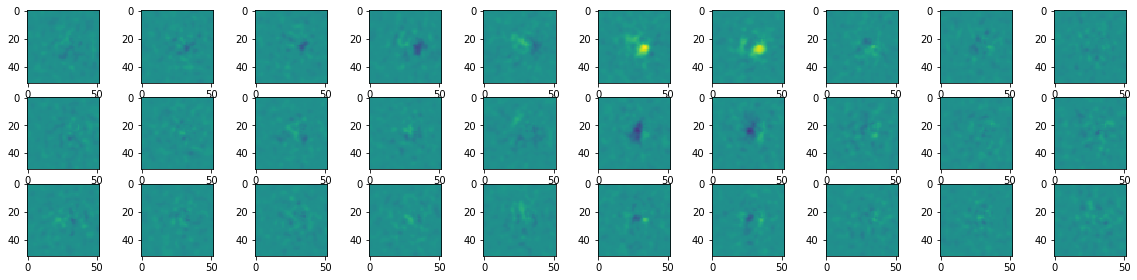

3135.219395875931 sec elapsed fitting GLM
Cell  22:  glm+abs   LL = 0.00506 -> 0.01098


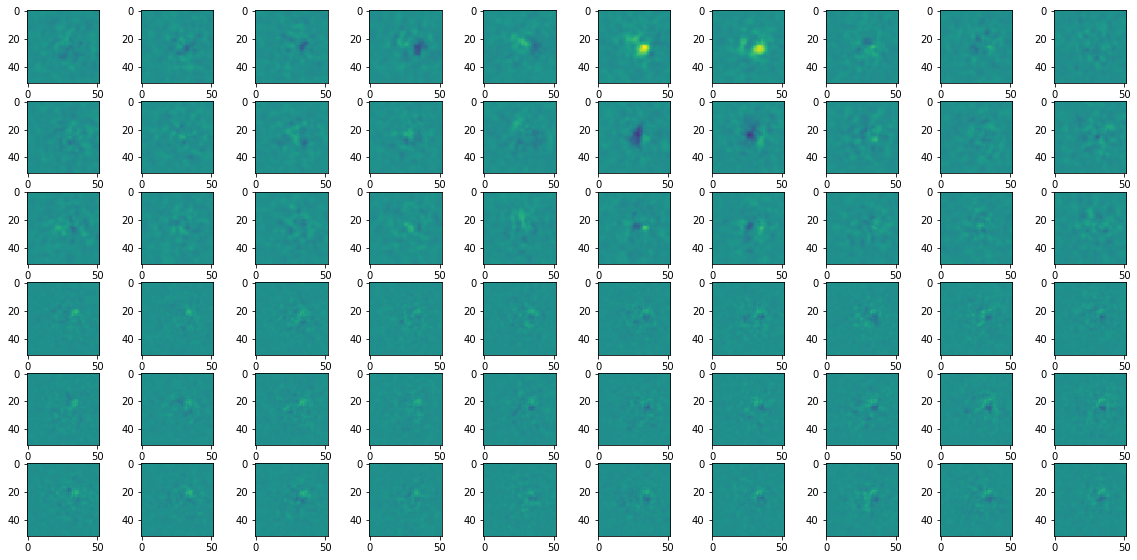

Output set to 1 cells
Cell  23:  d2x -R7   LLs = 0.007133841514587402
Cell  23:  d2t -R7   LL = 0.00713 -> 0.00879
Cell  23:  Gloc-R5   LL = 0.00713 -> 0.00945
Cell  23:  L1  -R4   LL = 0.00713 -> 0.00984


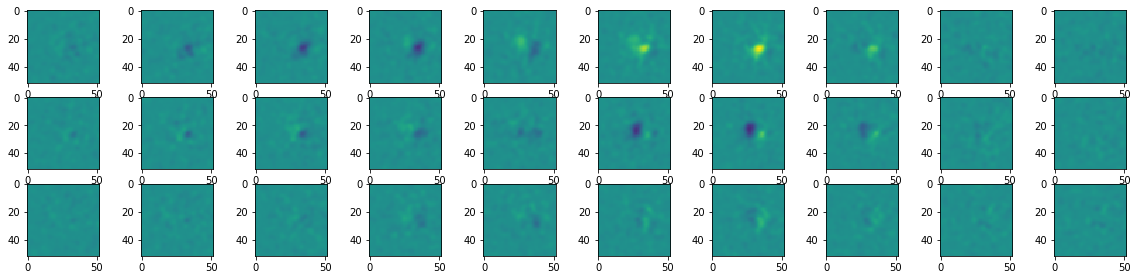

2513.790365457535 sec elapsed fitting GLM
Cell  23:  glm+abs   LL = 0.00713 -> 0.01172


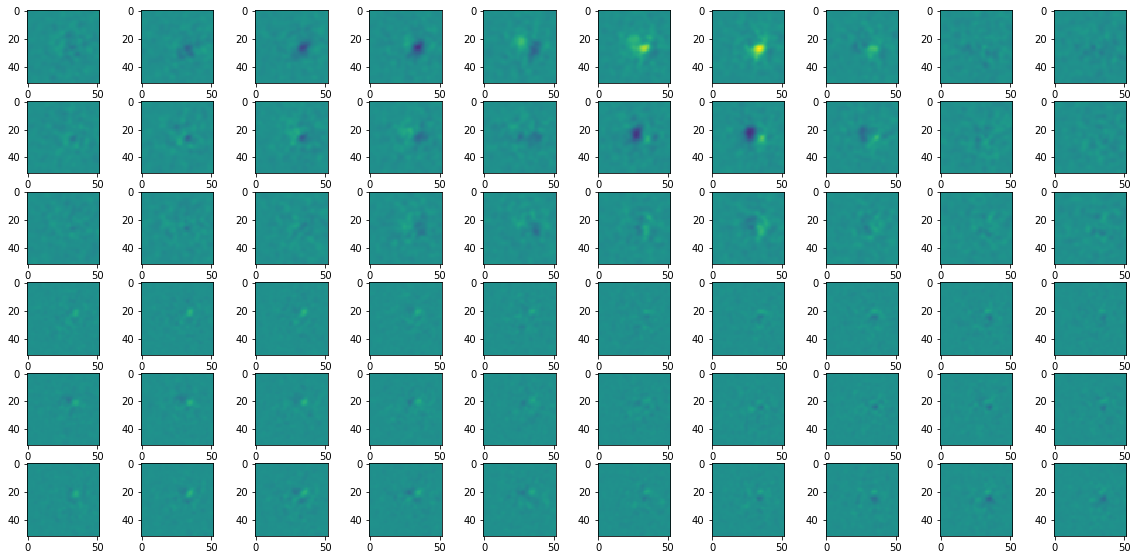

Output set to 1 cells
Cell  44:  d2x -R7   LLs = -0.006918907165527344
Cell  44:  d2t -R7   LL =-0.00692 ->-0.00111
Cell  44:  Gloc-R6   LL =-0.00692 -> 0.00197
Cell  44:  L1  -R4   LL =-0.00692 -> 0.00207


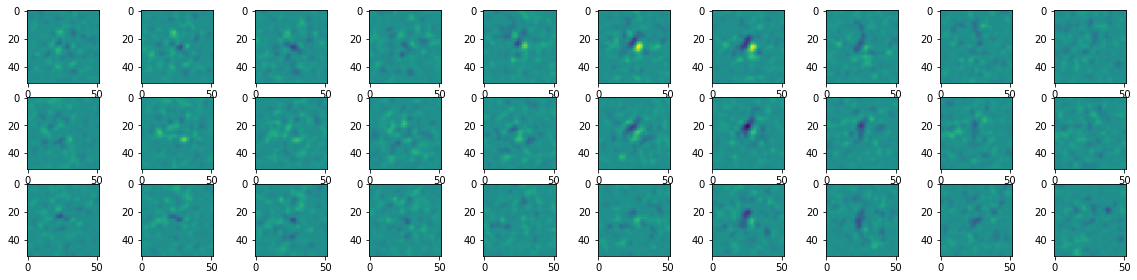

2689.443503141403 sec elapsed fitting GLM
Cell  44:  glm+abs   LL =-0.00692 -> 0.00560


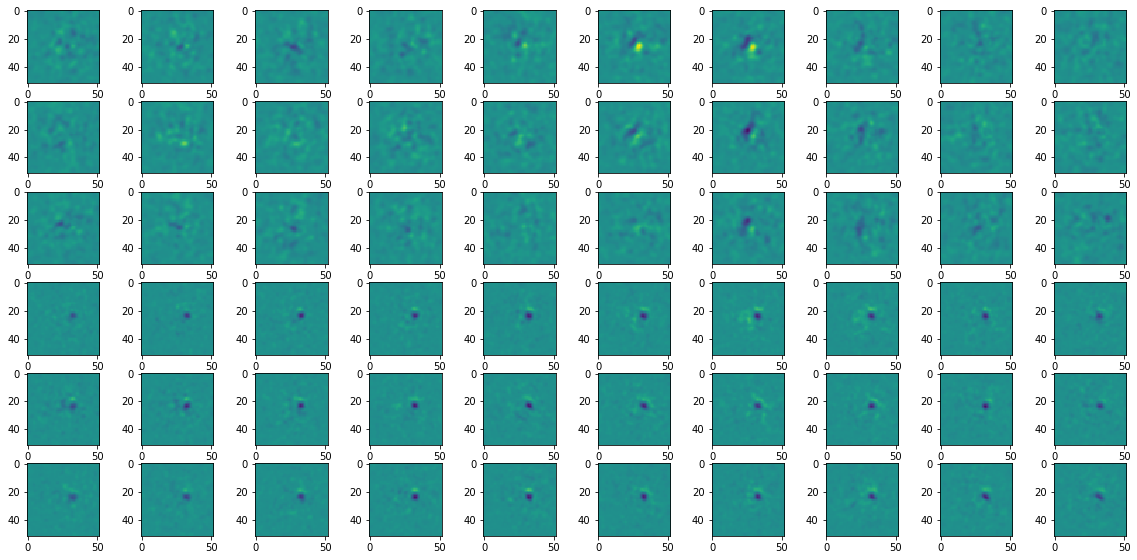

Output set to 1 cells
Cell  60:  d2x -R1   LLs = -0.0019364356994628906
Cell  60:  d2t -R7   LL =-0.00194 ->-0.00144
Cell  60:  Gloc-R6   LL =-0.00194 -> 0.00223
Cell  60:  L1  -R4   LL =-0.00194 -> 0.00229


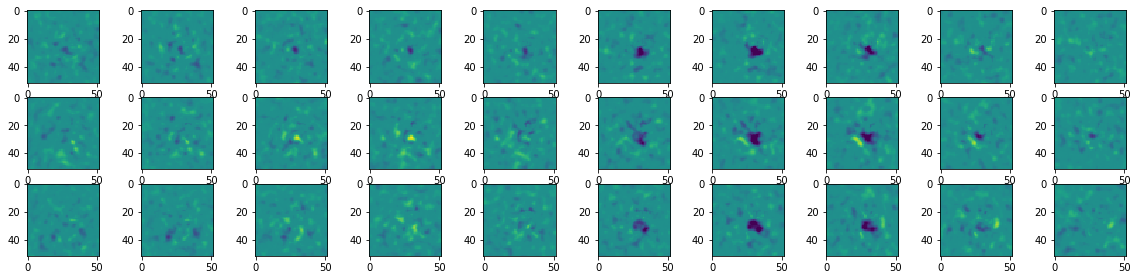

3830.9664540290833 sec elapsed fitting GLM
Cell  60:  glm+abs   LL =-0.00194 -> 0.01094


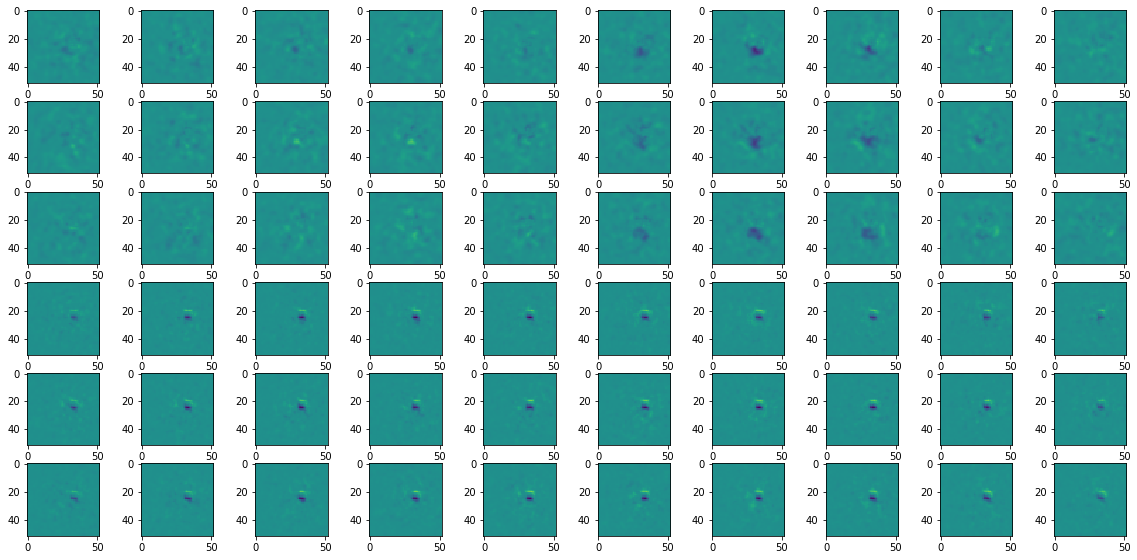

Output set to 1 cells
Cell  69:  d2x -R1   LLs = -2.09808349609375e-05
Cell  69:  d2t -R7   LL =-0.00002 -> 0.00191
Cell  69:  Gloc-R5   LL =-0.00002 -> 0.00281
Cell  69:  L1  -R4   LL =-0.00002 -> 0.00308


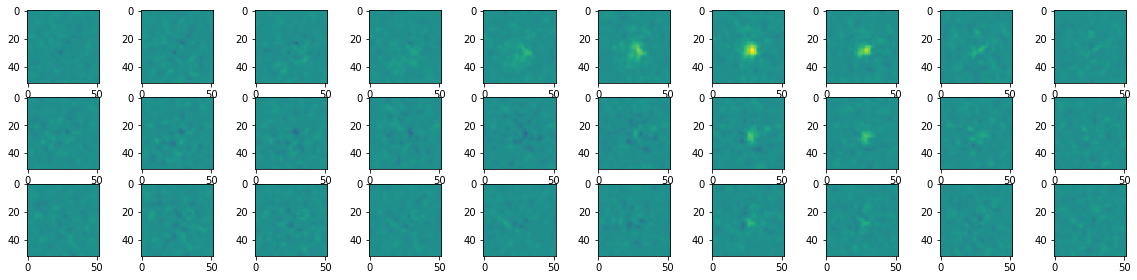

3293.5876879692078 sec elapsed fitting GLM
Cell  69:  glm+abs   LL =-0.00002 -> 0.00340


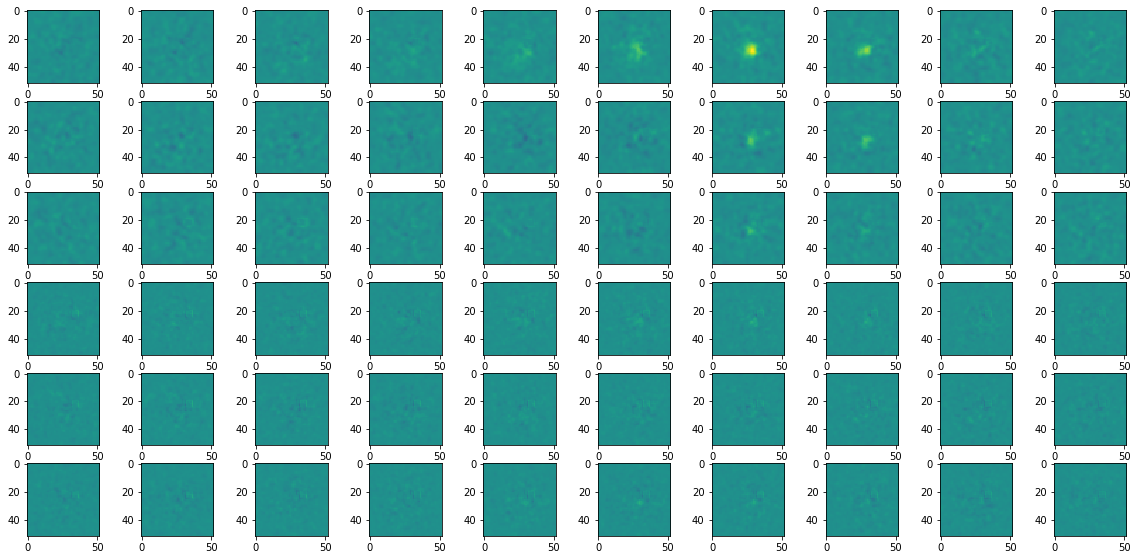

Output set to 1 cells
Cell  83:  d2x -R0   LLs = 0.0029730796813964844
Cell  83:  d2t -R7   LL = 0.00297 -> 0.00636
Cell  83:  Gloc-R5   LL = 0.00297 -> 0.00728
Cell  83:  L1  -R4   LL = 0.00297 -> 0.00768


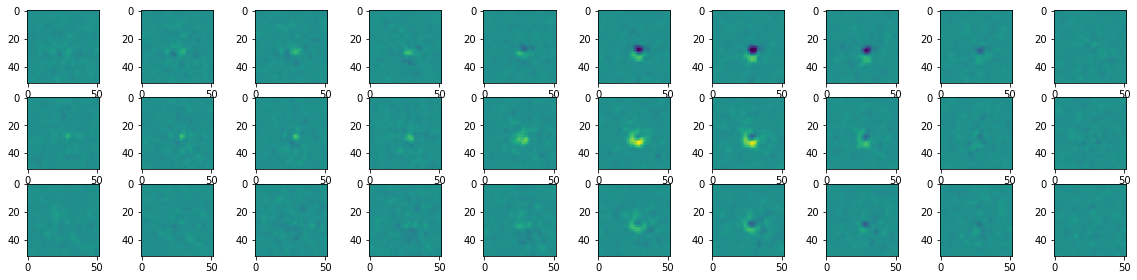

3609.482661485672 sec elapsed fitting GLM
Cell  83:  glm+abs   LL = 0.00297 -> 0.00732


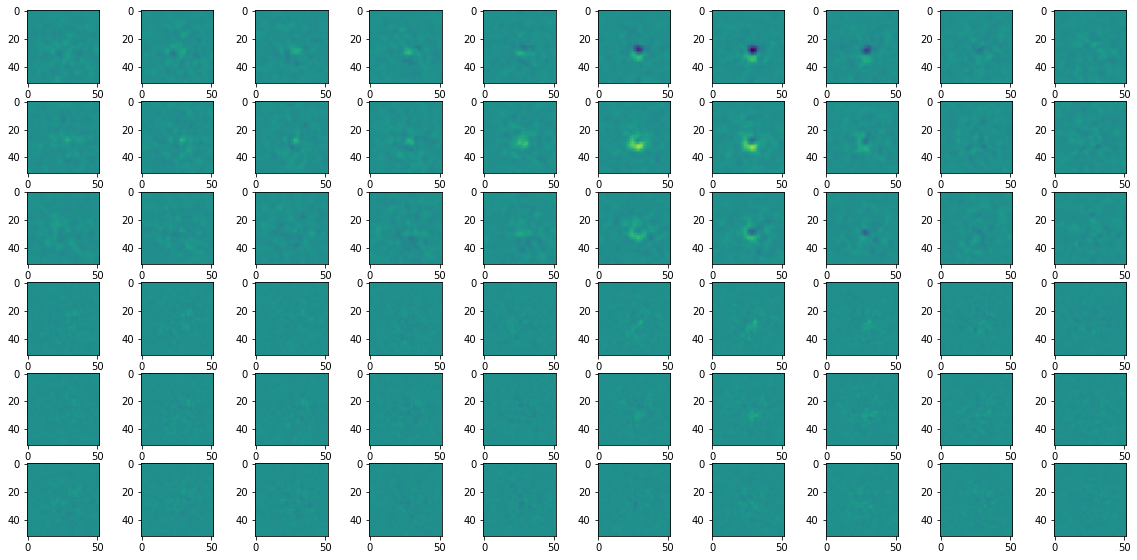

In [20]:
# now fit across all models
for cc in targ_cells:
    #cc=0
    t0=time()
    data.set_cells([valUT[cc]])

    # fit drift network
    drift_iter = NDN.NDN( 
        layer_list = [drift_pars1N], loss_type='poisson')
    drift_iter.block_sample=True
    drift_iter.networks[0].xstim_n = 'Xdrift'
    drift_iter.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
    LLsNULL[cc] = drift_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
    driftmods[cc] = deepcopy(drift_iter)

    # first fit GLM
    LLs = np.zeros(len(rvals))+1000
    for rr in range(len(rvals)):
        stim_net['layer_list'][0]['reg_vals']['d2x'] = rvals[rr]
        glm_iter = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_iter.block_sample=True
        glm_iter.networks[1].layers[0].weight.data[:,0] = deepcopy(
            driftmods[cc].networks[0].layers[0].weight.data[:,0])
        glm_iter.networks[1].layers[0].set_parameters(val=False)
        glm_iter.networks[2].layers[0].set_parameters(val=False,name='weight')

        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (rr == 0) or (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm1 = np.argmin(LLs)
    LLsR[cc,0] = LLs[bm1]
    XTopt[cc] = rvals[bm1]
    glms[cc] = deepcopy(best_model)
    print( "Cell %3d:  d2x -R%d   LLs ="%(cc, bm1), LLsNULL[cc]-LLsR[cc,0] )

    LLs = np.zeros(len(rvals))+LLsR[cc,0]
    for rr in range(len(rvals)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['d2t'] = rvals[rr]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm1b = np.argmin(LLs)
    LLsR[cc,1] = LLs[bm1b]
    GLopt[cc] = rvals[bm1b]
    glms[cc] = deepcopy(best_model)
    print( "Cell %3d:  d2t -R%d   LL =%8.5f ->%8.5f"%(cc, bm1b, LLsNULL[cc]-LLsR[cc,0], LLsNULL[cc]-LLsR[cc,1]) )

    LLs = np.zeros(len(rvalsG))+np.min(LLsR[cc,:2])
    for rr in range(len(rvalsG)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[rr]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm2 = np.argmin(LLs)
    LLsR[cc,2] = LLs[bm2]
    GLopt[cc] = rvals[bm2]
    glms[cc] = deepcopy(best_model)
    print( "Cell %3d:  Gloc-R%d   LL =%8.5f ->%8.5f"%(cc, bm2, LLsNULL[cc]-LLsR[cc,0], LLsNULL[cc]-LLsR[cc,2]) )

    LLs = np.zeros(len(rvals))+np.min(LLsR[cc,:3])
    for rr in range(1,len(rvals)):
        glm_iter = deepcopy(best_model)
        glm_iter.networks[0].layers[0].reg.vals['l1'] = rvals[rr]
        glm_iter.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
        LLi = glm_iter.eval_models(data[data.val_blks], null_adjusted=False)[0]
        if (LLi < np.min(LLs)):
            best_model = deepcopy(glm_iter)
        LLs[rr] = LLi

    bm3 = np.argmin(LLs)
    LLsR[cc,3] = LLs[bm3]
    GLopt[cc] = rvals[bm3]
    glms[cc] = deepcopy(best_model)
    print( "Cell %3d:  L1  -R%d   LL =%8.5f ->%8.5f"%(cc, bm3, LLsNULL[cc]-LLsR[cc,0], LLsNULL[cc]-LLsR[cc,3]) )
    best_glm = deepcopy(best_model)

    # plot GLM filters
    w = best_model.get_weights()
    utils.subplot_setup(1,num_lags, row_height=4)
    for ll in range(num_lags):
        plt.subplot(3,num_lags,ll+1)
        utils.imagesc(w[0,:,:,ll,0], aspect=1, max=np.max(w))
        plt.subplot(3,num_lags,ll+1+num_lags)
        utils.imagesc(w[1,:,:,ll,0], aspect=1, max=np.max(w))
        plt.subplot(3,num_lags,ll+1+num_lags*2)
        utils.imagesc(w[2,:,:,ll,0], aspect=1, max=np.max(w))
    plt.show()

    t1 = time()
    print(t1-t0, 'sec elapsed fitting GLM')
    
    ## also fit GLM-abs?
    glm_abs = NDN.NDN(ffnet_list = [stim_net2, drift_net, net_comb], loss_type='poisson')
    glm_abs.block_sample=True
    glm_abs.networks[1].layers[0].weight.data[:,0] = deepcopy(
        driftmods[cc].networks[0].layers[0].weight.data[:,0])
    # also initialize with previous GLM filter?
    glm_abs.networks[2].layers[0].set_parameters(val=False,name='weight')
    glm_abs.networks[1].layers[0].set_parameters(val=False)
    glm_abs.networks[0].layers[0].reg.vals['d2x'] = rvals[bm1]
    glm_abs.networks[0].layers[0].reg.vals['d2t'] = rvals[bm1b]
    glm_abs.networks[0].layers[0].reg.vals['glocalx'] = rvalsG[bm2]
    glm_abs.networks[0].layers[0].reg.vals['l1'] = rvals[bm3]

    glm_abs.fit( data, force_dict_training=True, **lbfgs_pars, seed=5, version=9, verbose=0)
    LL_abs[cc] = glm_abs.eval_models(data[data.val_blks], null_adjusted=False)[0]
    glms_abs[cc] = deepcopy(glm_abs)
    print( "Cell %3d:  glm+abs   LL =%8.5f ->%8.5f"%(cc, LLsNULL[cc]-LLsR[cc,0], LLsNULL[cc]-LL_abs[cc]) )

    # plot glm_abs
    w2 = glms_abs[cc].get_weights()
    w2=w2.reshape([2,3,NXglm,NXglm,num_lags,1])
    maxlin = np.max(w2[0,:,:,:,:,:])
    maxabs = np.max(w2[1,:,:,:,:,:])
    maxall = np.max(abs(w2))
    utils.ss(2,num_lags, rh=4)
    for ll in range(num_lags):
        plt.subplot(6,num_lags,ll+1)
        utils.imagesc(w2[0,0,:,:,ll,0], aspect=1, max=maxall)
        plt.subplot(6,num_lags,ll+1+num_lags)
        utils.imagesc(w2[0,1,:,:,ll,0], aspect=1, max=maxall)
        plt.subplot(6,num_lags,ll+1+num_lags*2)
        utils.imagesc(w2[0,2,:,:,ll,0], aspect=1, max=maxall)
        plt.subplot(6,num_lags,ll+1+num_lags*3)
        utils.imagesc(w2[1,0,:,:,ll,0], aspect=1, max=maxall)
        plt.subplot(6,num_lags,ll+1+num_lags*4)
        utils.imagesc(w2[1,1,:,:,ll,0], aspect=1, max=maxall)
        plt.subplot(6,num_lags,ll+1+num_lags*5)
        utils.imagesc(w2[1,2,:,:,ll,0], aspect=1, max=maxall)
    plt.show()



In [21]:
glm_ks = np.zeros([NCv, 3, NXglm, NXglm, num_lags]) 
glm_abs_ks = np.zeros([NCv, 6, NXglm, NXglm, num_lags]) 

LLsGLM = LLsNULL-np.min(LLsR,axis=1)
LLsGLMabs = LLsNULL-LL_abs

for cc in targ_cells:
    glm_ks[cc,:,:,:,:] = glms[cc].get_weights().squeeze()
    glm_abs_ks[cc,:,:,:,:] = glms_abs[cc].get_weights().squeeze()
    
sio.savemat(analdir+PROOT+'_UT_GLM'+ConvID+'_measures1.mat', {
    'glm_ks':glm_ks, 'glm_abs_ks':glm_abs_ks, 'targ_cells':targ_cells,
    'valUT':valUT, 'LLsGLM':LLsGLM[:, None],'LLsGLMabs':LLsGLMabs[:, None]})

In [22]:
# Assemble population drift terms
w0 = driftmods[0].get_weights()
NA = w0.shape[0]
drift_terms = np.zeros([NA, NCv])
for cc in targ_cells:
    drift_terms[:, cc] = deepcopy(driftmods[cc].get_weights())[:,0]

# Assemble drift population model
drift_pars_pop = NDNLayer.layer_dict( 
    input_dims=[1,1,1,NA], num_filters=NCv, bias=False, norm_type=0, NLtype='softplus')
drift_pars_pop['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0} } 
drift_pop = NDN.NDN( layer_list = [drift_pars_pop], loss_type='poisson')
drift_pop.block_sample=True
drift_pop.networks[0].xstim_n = 'Xdrift'
drift_pop.networks[0].layers[0].weight.data = torch.tensor(drift_terms, dtype=torch.float32)
data.cells_out = list(valUT)
LLsCHECK = drift_pop.eval_models(data[data.val_blks], null_adjusted=False) 
print(np.mean(LLsNULL), np.mean(LLsCHECK))

AttributeError: 'NoneType' object has no attribute 'get_weights'

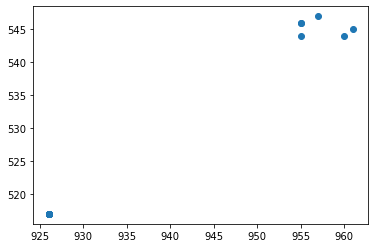

In [23]:
# Get array centers
RFcenters = np.zeros([NCv,2], dtype=np.int64) - 1
RFcols = np.zeros([NCv,1], dtype=np.int64) - 1
for cc in targ_cells:
    k = glms[cc].get_weights()
    pfilt = np.sum(np.std(k, axis=3),axis=0).squeeze() # for colorRFs
    x,y = utils.max_multiD( pfilt )
    RFcenters[cc, :] = [x,y]

RFcenters[:,0] = RFcenters[:,0] + top_corner[0]
RFcenters[:,1] = RFcenters[:,1] + top_corner[1]
plt.plot(RFcenters[:, 0], RFcenters[:, 1],'o')
plt.show()

### now save

In [26]:
LLsGLM = LLsNULL-np.min(LLsR,axis=1)
LLsGLMabs = LLsNULL-np.min(LLsR,axis=1)
sio.savemat(datadir2+PROOT+'_UT_GLM'+ConvID+'_info1.mat', {
    'LLsNULL':LLsNULL[:,None], 'LLsGLM':LLsGLM[:, None], 'LLsGLMabs':LLsGLMabs[:, None],
    'drift_terms': drift_terms, 'Dreg': Dreg, 'valUT':valUT, 'NX':UNX,
    'RFcenters': RFcenters, 'top_corner': top_corner[:, None]})
#drift_pop.save_model(filename=moddir+'LP_drift_pop.pkl')

for cc in targ_cells:
    glms_abs[cc].save_model(filename=moddir+'UT' + utils.filename_num2str(cc, num_digits=3) + 'glm'+ConvID+'wET.pkl')


  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT022glmConeIncwET.pkl
  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT023glmConeIncwET.pkl
  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT044glmConeIncwET.pkl
  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT060glmConeIncwET.pkl
  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT069glmConeIncwET.pkl
  Saving model at /Data/FelixData/Conway/proc/J220715/models/UT083glmConeIncwET.pkl


In [ ]:
print("DONE!!!")